# 목차
<b><전국 데이터></b>
 1. 데이터 전처리<br><br>
 2. EDA(데이터 탐색)<br>
    1) 지역별 평균 신용평점 및 개설 카드 수<br>
    2) 연령별 월 평균 카드이용금액<br>
    3) 월별 평균 대출금액<br>
    4) 지역별 월별 평균 대출금액 비교<br>
    5) 지역별 분양가격과 평균 대출금액의 상관관계<br>
    6) 전체 변수 상관관계<br><br>
 3. 분석<br>
    1) 고신용/저신용 그룹 간의 비교 분석<br>
    2) Feature Selection<br>
    3) 지역별 연령별 군집 특성 비교 분석<br>
    - Elbow Method<br>
    - K-Means Clustering<br>
    - Factor Analysis<br><br><br>
<b><제주 데이터></b>
 1. EDA(데이터 탐색)<br>
     1). 직업관련 및 부채관련 분포<br>
     2). 성별 소득/소비/부채<br>
     3). 연령별 소득/소비/부채<br><br>
 2. 분석    <br>
     1). 지역별 군집화<br>
       - Data preprocessing<br>
       - Elbow Method<br>
       - K-Means Clustering<br>
       - 3차원으로 군집화 결과 확인<br>
       - 지도 시각화<br>
       - 군집 결과 분석<br>
            (i) cluster0 분석 결과<br>
            (ii) cluster1 분석 결과<br><br>
 3. 인사이트 발굴<br>
    1) 현황<br>
    2) 가설<br>
    3) 가설검증<br>
    - 위도, 경도 정보로 읍/면/동 정보 얻어내기<br>
    - 시각를 위한 데이터 전처리<br>
    - 시각화<br>
    - 데이터 확인 결과<br>

In [2]:
# system
import re
import requests
import os
import random
from tqdm import tqdm_notebook
import warnings 
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# dataframe
import pandas as pd
import numpy as np
import json
import folium

In [4]:
# pyecharts
from __future__ import unicode_literals
import pyecharts
from pyecharts import Bar, Line, Grid, Funnel, Pie, Scatter3D, HeatMap, EffectScatter, Overlap
from pyecharts import Page,Timeline, online, Radar
online() 
print("pyecharts version : ", pyecharts.__version__)

pyecharts version :  0.5.8


In [5]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

* 필요 모듈 설치
- plotly : pip install plotly
- pyecharts : pip install pyecharts == 0.5.8

In [6]:
import plotly 
#plotly.tools.set_credentials_file(username='kd5566', api_key='29xviZgAvZqYVyXWw244')

In [7]:
# visualization
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import cm
%matplotlib inline

## plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

"""
# 폰트설정 - 나눔바른고딕
import matplotlib.font_manager as fm
path = 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
"""
# 폰트설정 - 맑은고딕
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Malgun Gothic'

In [8]:
import vincent
vincent.core.initialize_notebook()

In [9]:
# analyizer
from collections import Counter
from dateutil.parser import parse
from datetime import datetime, timedelta
import time
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# <전국 데이터>

# 1. 데이터 전처리

In [10]:
df = pd.read_csv("data/credit_card_data.csv", encoding='utf-8')
df.head(3)

,pop_cd,year,month,avg_score,avg_rat,city,sex,ages,population,num_opencard,...,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016,1,812,2,서울,NaN,10대,55000,1.44,...,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016,2,773,4,서울,NaN,10대,380000,1.71,...,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016,3,771,4,서울,NaN,10대,387000,1.75,...,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000


- 기존 data는 모든 Feature들이 고객구분 코드 그룹의 평균으로 되어 있다. 따라서 그룹 간 집계를 할 때, population이 고려되지 않으므로 매크로 평균(Macro Average)를 구하게 된다. 이에 각 Feature에 population을 곱한 열을 추가하여 마이크로 평균(Micro Average)을 구하였다.
<br>

- 총 28개 column 사용
    - pop_cd, year, month, avg_score, avg_rat, city, sex, population
    - total_avg_score
    - total_avg_rat
    - total_num_opencard
    - total_num_usecard
    - total_monthly_card_spend
    - total_monthly_lc
    - total_monthly_loan
    - total_monthly_bk_loan
    - total_monthly_cd_loan
    - total_monthly_installments_loan
    - total_monthly_insurance_loan
    - total_monthly_sbk_loan
    - total_loan_commitment
    - total_inst_rep_loanb
    - total_ls_rep_loanb
    - total_credit_loan
    - total_mortgage_loan
    - total_credit_card_payment
    - total_credit_card_installments_payment

In [11]:
df_total = df.iloc[:, :9]
for col in df.columns[3:]:
    if type(df['{}'.format(col)][0]) in [np.int64, np.float64] and col!='population':
        colname = 'total_' + col
        df_total['{}'.format(colname)] = df['{}'.format(col)] * df.population
df_total.head(3)

,pop_cd,year,month,avg_score,avg_rat,city,sex,ages,population,total_avg_score,...,total_monthly_installments_loan,total_monthly_insurance_loan,total_monthly_sbk_loan,total_loan_commitment,total_inst_rep_loanb,total_ls_rep_loanb,total_credit_loan,total_mortgage_loan,total_credit_card_payment,total_credit_card_installments_payment
0,L011,2016,1,812,2,서울,NaN,10대,55000,44660000,...,0,0,0,61600000000,451550000000,4291100000000,5069350000000,4799300000000,0,0
1,L011,2016,2,773,4,서울,NaN,10대,380000,293740000,...,193800000000,83600000000,387600000000,258400000000,1770800000000,8854000000000,3138800000000,16115800000000,1520000000,380000000
2,L011,2016,3,771,4,서울,NaN,10대,387000,298377000,...,189630000000,81270000000,441180000000,247680000000,1691190000000,8873910000000,3212100000000,16141770000000,1161000000,387000000


In [12]:
# 시계열 시각화 위한 '년-월-일' 형식으로 변경하기 위해 임의로 매월 1일 값으로 설정
df['year'] = df['year'].apply(str)
df['month'] = df['month'].apply(str)
df['date'] = df['year'] + ' ,' + df['month'] + ' ,1'
df['date'] = pd.to_datetime(df['date'])

df_total['year'] = df_total['year'].apply(str)
df_total['month'] = df_total['month'].apply(str)
df_total['date'] = df_total['year'] + ' ,' + df_total['month'] + ' ,1'
df_total['date'] = pd.to_datetime(df_total['date'])

# 총 29개의 column

In [13]:
# 도시별, 성별 데이터프레임 분리
city_ages = df[df['pop_cd'].str.startswith('L')]
sex_ages = df[df['pop_cd'].str.startswith('Y')]
# 필요없는 컬럼 삭제
city_ages = city_ages.drop('sex', axis=1)
sex_ages = sex_ages.drop('city', axis=1)

# 도시별, 성별 데이터프레임 분리
city_ages_total = df_total[df_total['pop_cd'].str.startswith('L')]
sex_ages_total = df_total[df_total['pop_cd'].str.startswith('Y')]
# 필요없는 컬럼 삭제
city_ages_total = city_ages_total.drop('sex', axis=1)
sex_ages_total = sex_ages_total.drop('city', axis=1)

# <br>
# 2. EDA(데이터 탐색)

## 1) 지역별 평균 신용평점 및 개설 카드 수

In [14]:
# folium 지도 시각화를 위한 GeoJSON load
with open(r'./data/skorea-provinces-2018-geo.json') as f:
    json_data = json.load(f)

In [15]:
# GeoJSON data와 주어진 credit card data의 지역명을 통일하기 위한 dictionary 선언
provinces_dict = {'서울특별시': '서울',
                  '부산광역시': '부산',
                  '대구광역시': '대구',
                  '인천광역시': '인천',
                  '광주광역시': '광주',
                  '대전광역시': '대전',
                  '울산광역시': '울산',
                  '세종특별자치시': '세종',
                  '경기도': '경기',
                  '강원도': '강원',
                  '충청북도': '충북',
                  '충청남도': '충남',
                  '전라북도': '전북',
                  '전라남도': '전남',
                  '경상북도': '경북',
                  '경상남도': '경남',
                  '제주특별자치도': '제주'}

In [16]:
# 제공된 데이터에 맞게 광역시도명 변경
for feature in json_data['features']:
    feature['properties']['name'] = provinces_dict.get(feature['properties']['name'])

In [18]:
# population을 고려한 data 전처리
city_group = city_ages_total.groupby('city').sum()[['population', 'total_avg_score']]
city_group['avg_score'] = round(city_group['total_avg_score'] / city_group['population'])
city_group = city_group.reset_index()

# 지역별 평균 신용평점 표 시각화
table = ff.create_table(city_group)
table['layout'].update(height=400,width=500)
plotly.offline.iplot(table)

# 지역별 평균 신용평점 지도 시각화
country_map = folium.Map(location=[35.865779, 127.862596], zoom_start=7, tiles='cartodbpositron')
folium.Choropleth(
    geo_data=json_data,
    data=city_group,
    columns=['city', 'avg_score'],
    key_on='feature.properties.name',
    fill_color='YlGn',
).add_to(country_map)

country_map.save('avg_score_by_city.html')

<img src="./data/newplot_table.png" alt="지역별 평균 평점 스크린샷" style="width: 400px;"/>

<a href="./avg_score_by_city.html">지역별 평균 평점 (클릭하세요)</a><br/>
- 커널 환경에 따라 jupyter notebook에 inline으로 뜨지 않는 상황을 위해 html 링크를 첨부
- 아래의 이미지는 html링크를 클릭하면 나타나는 화면의 스크린샷

<img src="./data/avg_score_by_city.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 세종시의 경우 현 행정구역 상 구분되어 있으나, 제공된 데이터에서는 구분되지 않아 검은색으로 나타남
- 서울특별시와 광역시 고객의 평균 평점이 다른 지역에 비해 높은 것으로 나타남

In [19]:
# population을 고려한 data 전처리
city_card = city_ages_total.groupby('city').sum()[['population', 'total_num_opencard']]
city_card['avg_opencard'] = round(city_card['total_num_opencard'] / city_card['population'],2)
city_card = city_card.reset_index()

# 지역별 평균 개설카드 수 표 시각화
table = ff.create_table(city_card)
table['layout'].update(height=400,width=600)
plotly.offline.iplot(table)

# 지역별 평균 개설카드 수 지도 시각화
country_map = folium.Map(location=[35.865779, 127.862596], zoom_start=7, tiles='cartodbpositron')
folium.Choropleth(
    geo_data=json_data,
    data = city_card,
    columns=['city', 'avg_opencard'],
    key_on='feature.properties.name',
    fill_color='YlGn',
).add_to(country_map)

country_map.save('open_card_by_city.html')

<img src="./data/newplot_cardtable.png" alt="지역별 평균 평점 스크린샷" style="width: 400px;"/>

<a href="./open_card_by_city.html">지역별 평균 카드개설 수 (클릭하세요)</a><br/>

<img src="./data/avg_opencard_by_city2.png" alt="지역별 평균 카드개설 수 스크린샷" style="width: 800px;"/>

- 상대적으로 인구가 많은 특별시와 광역시를 중심으로 한 일부 지역에서 개설 카드 수가 많은 모습을 확인할 수 있다.

## 2) 연령별 월 평균 카드이용금액

In [20]:
# population을 고려한 data 전처리
test_sum = city_ages_total.groupby(['ages','date'])['total_monthly_card_spend'].sum()/ city_ages_total.groupby(['ages','date'])['population'].sum()
test_sum.index = sorted(set(pd.date_range('2016-01', '2017-12').strftime("%Y%m")))*9

# pyecharts module을 활용한 연령별 월 평균 카드이용금액 시각화
line = Line("연령별 월 평균 카드이용금액", '단위(만원)', title_top="0%")
attr = sorted(set(pd.date_range('2016-01', '2017-12').strftime("%Y%m")))
for i in range(0,9):
    label_name = str(i+1)+'0대'
    line.add(
        label_name,
        attr,
        round(test_sum[i*24 : (i+1)*24]/10000, 0),
        mark_point=["max", "min"],
        mark_line=["average"],
        symbol='roundRect', effect_scale=5,
        legend_top="5%"
    )
grid = Grid(height=550, width=900)
grid.add(line, grid_bottom="10%")
grid

<img src="./data/연령별_월카드이용금액.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

## 3) 월별 평균 대출금액

In [21]:
# plotly module을 활용한 line plot 함수 정의
def plotly_line(data, line_color, yaxis_name, data_name):
    trace = go.Scatter(x=data.index, y=data.values, 
                       yaxis= yaxis_name, name = data_name,  
                       showlegend = True, marker=dict(color=line_color)
                      )
    return trace

In [22]:
# population을 고려한 data 전처리
col_name = 'total_monthly_loan'
avg_mon_loan = city_ages_total.groupby('date')[col_name].sum() / city_ages_total.groupby('date')['population'].sum()

# 월 평균 대출금액 시각화
trace = [plotly_line(avg_mon_loan, 'cornflowerblue', 'y1', 'total_loan')]
layout = go.Layout(height=500, width=900, title= col_name)
fig = go.Figure(data= trace, layout=layout)
py.iplot(fig)

<img src="./data/total_monthly_loan.png" alt="지역별 평균 평점 스크린샷" style="width:800px;"/>

- 2016년부터 2017년까지 전국민의 대출 금액이 증가하는 것을 확인할 수 있다.

In [23]:
# population을 고려한 data 전처리
avg_credit_loan = city_ages_total.groupby('date')['total_credit_loan'].sum() / city_ages_total.groupby('date')['population'].sum()
avg_mortgage_loan = city_ages_total.groupby('date')['total_mortgage_loan'].sum() / city_ages_total.groupby('date')['population'].sum()

In [24]:
# 월 평균 신용 대출 및 담보 대출 시각화
trace = [plotly_line(avg_credit_loan, 'tomato', 'y1', 'credit loan'),
         plotly_line(avg_mortgage_loan, 'cornflowerblue', 'y2', 'mortgage loan')]

layout = go.Layout(
    height=500,
    width=900,
    title='Credit & Mortgage loan',
    yaxis2= dict(
    overlaying='y',
    side='right',
    showgrid=False),
    legend=dict(x=1.05, y=1.1)
)

fig = go.Figure(data= trace, layout=layout)
py.iplot(fig)

<img src="./data/credit_mortgage_loan.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 총대출금액을 담보대출과 신용대출로 나누어 확인한 결과, 담보대출의 경우 전반적으로 우상향하지만, 2017년 7월부터 하락세를 보이며 두 달 뒤인 2017년 9월에 저점을 찍고 다시 상승하는 모습을 보인다. 

- 이러한 경향은 지난 2017년 7월 3일부터 적용된 주택담보대출에 대한 대출 규제 강화에 대한 것에서 기인한 것으로 추정된다.

- 또한, 담보대출이 감소한 기간동안 '풍선효과'로 인하여 신용대출의 증가율이 상승한 모습을 확인할 수 있다.

경제활동이 가장 활발한 30대에서 50대가 가장 많은 카드 소비량을 보이고, 상대적으로 경제활동의 비율이 낮은 10대와 80, 90대가 카드 이용 금액이 가장 적은 것을 확인할 수 있다.

## 4) 지역별 월별 평균 대출금액 비교

In [25]:
# folium 지도 상의 marker 표시를 위해 지역의 대표 위도/경도 값 지정
provinces_loc_dict = {
    '서울': [37.545965, 126.980173],
    '부산': [35.167870, 129.036722],
    '대구': [35.824940, 128.565634],
    '인천': [37.449330, 126.701160],
    '광주': [35.148111, 126.833837], 
    '대전': [36.329334, 127.394530], 
    '울산': [35.538384, 129.258463], 
    '세종': [36.561060, 127.258143], 
    '경기': [37.448048, 127.518384], 
    '강원': [37.850693, 128.121795], 
    '충북': [37.012076, 127.691009], 
    '충남': [36.562357, 126.843652], 
    '전북': [35.703964, 127.135653], 
    '전남': [34.940122, 126.880093], 
    '경북': [36.328086, 128.885263], 
    '경남': [35.455090, 128.320271], 
    '제주': [33.358634, 126.552228]
}

In [26]:
# population을 고려한 data 전처리
city_avg_loan = city_ages_total.groupby('city').sum()[['population', 'total_monthly_loan']]
city_avg_loan['monthly_loan'] = round(city_avg_loan['total_monthly_loan'] / city_avg_loan['population'])
city_avg_loan = city_avg_loan.reset_index()

In [27]:
# 지역별 연령별 총 대출금액 대비 각 대출 종목의 비중 계산
percent_monthly_loan = city_ages_total.groupby(['city', 'ages']).sum()[['total_monthly_loan', 
                                                                        'total_monthly_bk_loan', 'total_monthly_cd_loan', 
                                                                        'total_monthly_installments_loan', 'total_monthly_insurance_loan',
                                                                        'total_monthly_sbk_loan']]

percent_monthly_loan['percent_monthly_bk_loan'] = round(percent_monthly_loan['total_monthly_bk_loan'] / percent_monthly_loan['total_monthly_loan'], 3)
percent_monthly_loan['percent_monthly_cd_loan'] = round(percent_monthly_loan['total_monthly_cd_loan'] / percent_monthly_loan['total_monthly_loan'], 3)
percent_monthly_loan['percent_monthly_installments_loan'] = round(percent_monthly_loan['total_monthly_installments_loan'] / percent_monthly_loan['total_monthly_loan'], 3)
percent_monthly_loan['percent_monthly_insurance_loan'] = round(percent_monthly_loan['total_monthly_insurance_loan'] / percent_monthly_loan['total_monthly_loan'], 3)
percent_monthly_loan['percent_monthly_sbk_loan'] = round(percent_monthly_loan['total_monthly_sbk_loan'] / percent_monthly_loan['total_monthly_loan'], 3)
percent_monthly_loan = percent_monthly_loan.filter(regex=("percent*"))
percent_monthly_loan = percent_monthly_loan.reset_index()

In [28]:
# Vincent
# folium vincent marker를 위한 Json file 저장
for city, loc in provinces_loc_dict.items():
    bar = vincent.StackedBar(percent_monthly_loan[percent_monthly_loan['city']==city], 
                             columns=['percent_monthly_bk_loan', 'percent_monthly_cd_loan', 
                                      'percent_monthly_installments_loan', 'percent_monthly_insurance_loan', 
                                      'percent_monthly_sbk_loan'], 
                             key_on='ages')
    bar.width = 400
    bar.height = 200
    
    bar.x_axis_properties(label_align='center')
    bar.x_axis_properties(title_offset=10)
    bar.y_axis_properties(title_offset=-20)
    bar.scales[1].domain = [0, 1]
    
    bar.axis_titles(x='city', y='percent')
    bar.legend(title="columns")
    bar.to_json('vega_'+city+'.json')

In [29]:
# vincent 및 folium module을 활용한 지역별 월별 총 대출 금액 및 각 대출 종목의 비중 시각화
country_map = folium.Map(location=[35.865779, 127.862596], zoom_start=7, tiles='cartodbpositron')
folium.Choropleth(
    geo_data=json_data,
    data=city_avg_loan,
    columns=['city', 'monthly_loan'],
    key_on='feature.properties.name',
    fill_color='YlGn',
).add_to(country_map)

# vincent marker 추가
for city, loc in provinces_loc_dict.items():
    with open('vega_'+city+'.json') as f:
        vis = json.load(f)
        
    folium.RegularPolygonMarker(
        location=loc,
        popup=folium.Popup(max_width=700).add_child(
            folium.Vega(vis, width=630, height=260),
        ),
        color='#FFA301',
        fill_color='#FFA301',
        fill_opacity=1,
        radius=5
    ).add_to(country_map)

country_map.save('monthly_loan_by_city.html')

<a href="./monthly_loan_by_city.html">지역별 월별 총 대출 금액 및 업종별 차지하는 비중 (클릭하세요)</a><br/>
- 커널 환경에 따라 jupyter notebook에 inline으로 뜨지 않는 상황을 위해 html 링크를 첨부
- 아래의 이미지는 html링크를 클릭하면 나타나는 화면의 스크린샷

<img src="./data/monthly_loan_by_city.png" alt="지역별 월별 총 대출 금액 및 업종별 차지하는 비중 스크린샷" style="width: 800px;"/>

In [30]:
color_list = ['yellow','orange','pink','green','blue','navy','purple','black','brown','grey','lightskyblue','dodgerblue','yellowgreen','red','moccasin','olive']

# 지역별, 월별 평균 대출금액
trace_list = []
for city_name, co in zip(sorted(set(city_ages_total.city)), color_list):
    city_df = city_ages_total[city_ages_total['city'] == city_name]
    city_avg_loan = city_df.groupby('date')['total_monthly_loan'].sum() / city_df.groupby('date')['population'].sum() # population을 고려한 data 전처리
    trace_list.append(plotly_line(city_avg_loan, co, 'y1', city_name))

layout = go.Layout(
    height=600,
    width=800,
    title='Average monthly loan by City'
)

fig = go.Figure(data= trace_list, layout=layout)
py.iplot(fig)

<img src="./data/monthly_avgloan_by_city.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 지역별 평균 대출금액의 차이를 보면 수도권 및 광역시 지역이 대출 금액 상위권에 위치한 반면, 도단위 지역은 하위권에 위치한다.
- 이로 미루어 볼 때, 대출 금액은 지역별 주택가격, 즉 '땅 값'과 관련이 있을 것으로 예상된다.

"가계부채의 규모 중 상당 부분이 부동산과 연관이 있다는 것이다. 한국은행(2016)에 따르면 가계금융 대출의 용도별 비율은 거주주택 구입이 34% 로 가장 높았으며, 거주주택 외 부동산 구매 대출이 18%, 토지나 상가 투자를 위한 대출이 29%로 약 63%가 부동산 관련 대출로 분석하여 발표했다."<br>
<br>
<i>
참고자료: 「주택담보대출 결정요인에 관한 연구 : 개인특성과 지역특성간의 영향력 비교를 중심으로」, 이찬영, 중앙대학교 대학원, 2017</i>

In [32]:
# 가장 가파른 대출금액 상승률을 보이는 제주도를 직관적으로 시각화
trace_list = []
for city_name in sorted(set(city_ages_total.city)):
    if city_name == '제주':
        co = 'red'
    else:
        co = 'grey'
    city_df = city_ages_total[city_ages_total['city'] == city_name]
    city_avg_loan = city_df.groupby('date')['total_monthly_loan'].sum() / city_df.groupby('date')['population'].sum() # population을 고려한 data 전처리
    trace_list.append(plotly_line(city_avg_loan, co, 'y1', city_name))

layout = go.Layout(
    height=600,
    width=800,
    title='Average monthly loan by City'
)

fig = go.Figure(data= trace_list, layout=layout)
py.iplot(fig)

<img src="./data/monthly_jejuloan.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 특히, 제주도의 평균 대출금액이 비교적 가파르게 상승하고 있다.
- 지역별 평당 분양가와 연관지어 확인한 결과는 다음과 같다.

In [34]:
# 지역별 규모별 평균 분양가격 data load
house_price_df = pd.read_csv("./data/지역별_규모별_평균_분양가격.csv", engine='python', encoding="euc-kr")

데이터출처 : 주택도시보증공사, 「민간아파트분양시장동향」, 지역별 규모별 ㎡당 평균 분양가격 <br>
기간 : 2016.01 ~ 2017.12 <br>
단위 : 천원/㎡

## 5) 지역별 분양가격과 평균 대출금액의 상관관계

In [38]:
house_price_df.head(5)

,지역별(1),지역별(2),2016. 01,2016. 02,2016. 03,2016. 04,2016. 05,2016. 06,2016. 07,2016. 08,...,2018. 03,2018. 04,2018. 05,2018. 06,2018. 07,2018. 08,2018. 09,2018. 10,2018. 11,2018. 12
0,지역별(1),지역별(2),전체,전체,전체,전체,전체,전체,전체,전체,...,전체,전체,전체,전체,전체,전체,전체,전체,전체,전체
1,전국,소계,2740,2743,2747,2781,2794,2823,2828,2837,...,3202,3220,3255,3227,3206,3201,3257,3285,3304,3376
2,수도권,소계,4165,4174,4193,4226,4295,4318,4335,4360,...,4723,4719,4781,4664,4715,4715,4810,4985,5024,5041
3,수도권,서울,6108,6111,6173,6241,6264,6208,6254,6285,...,6836,6841,6919,6694,6820,6731,6994,7378,7369,7398
4,수도권,인천,3191,3192,3190,3238,3179,3204,3222,3235,...,3457,3457,3436,3372,3372,3343,3343,3440,3553,3548


In [36]:
# 지역별 분양가격과 평균 대출금액의 상관관계 계산
city_name_list = []
corr_list = []
for i in house_price_df['지역별(2)']:
    if i in sorted(set(city_ages_total.city)):
        for j in trace_list:
            if j['name'] == i:
                city_name_list.append(i)
                corr_list.append(np.corrcoef(j['y'], np.array(house_price_df[house_price_df['지역별(2)'] == i].iloc[0,2:26].astype('int64')))[0,1])

corr_df = pd.DataFrame(np.round(corr_list,2), index=city_name_list, columns=['corr']).T
corr_df['평균'] = np.mean(corr_list)
corr_df         

,서울,인천,경기,부산,대구,광주,대전,울산,강원,충북,충남,전북,전남,경북,경남,제주,평균
corr,0.81,0.53,0.76,0.84,0.58,0.88,0.75,0.79,0.46,0.37,0.61,0.88,0.94,0.94,0.68,0.93,0.734557


- 평균 약 0.73으로 강한 상관관계가 나타난다.

In [39]:
# 지역별 분양가격 시각화를 위한 데이터 전처리
house_price_df = house_price_df.iloc[3:, 1:-12].copy() # 필요없는 columns & rows 삭제
house_price_df = house_price_df.drop([6, 13]) # 소계 데이터 삭제

# 인덱스 초기화
house_price_df = house_price_df.reset_index()
house_price_df.drop(["index"], axis=1, inplace=True)

# 인덱스 도시 정보를 인덱스로 지정
house_price_df.rename(columns = {'지역별(2)':'city'}, inplace=True)
house_price_df.set_index("city", inplace=True)

# 그래프에서 시간을 나타내기 위해 object(string)에서 datetime 형식으로 변환
house_price_df.columns = pd.to_datetime(house_price_df.columns, format='%Y. %m').date

In [40]:
# 지역별 분양가격 시각화
trace_list = []
for city_name in sorted(house_price_df.index):
    if city_name == '제주':
        co = 'red'
    else:
        co = 'grey'
    trace_list.append(plotly_line(house_price_df.loc[city_name], co, 'y1', city_name))
    
layout = go.Layout(
    height=600,
    width=800,
    title='Average monthly house price by City'
)

fig = go.Figure(data= trace_list, layout=layout)
py.iplot(fig)

<img src="./data/monthly_houseprice_by_city.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 정리하자면, 지역별 땅 값(분양가)과 대출금액 사이에 높은 상관관계가 있음을 확인할 수 있다. 
- 따라서, 지가의 변동이 예상되는 지역에서는 대출금액 또한 함께 변동할 가능성이 크므로 적절한 대출 서비스 제공에 대응할 수 있다.

## 6) 전체 변수 상관관계

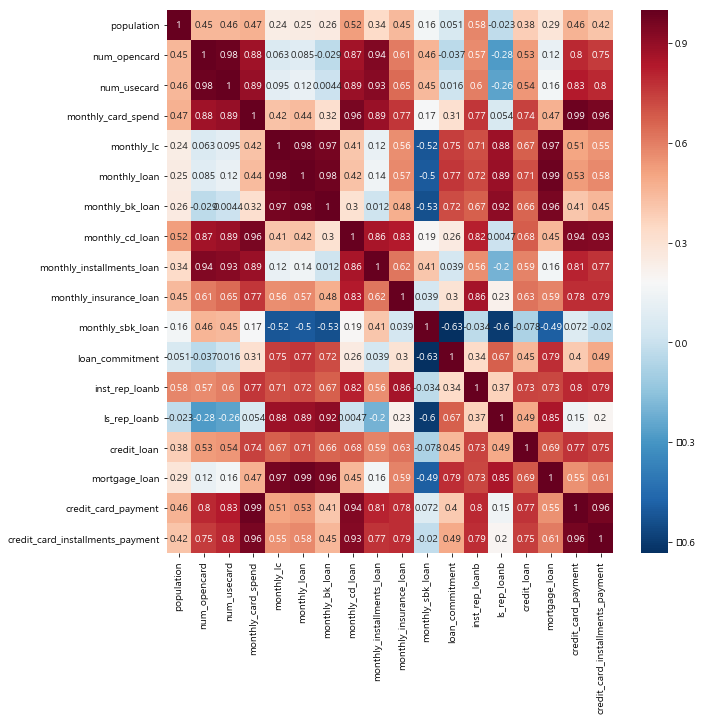

In [41]:
# heatmap을 활용한 각 변수들 간의 상관관계 시각화
plt.figure(figsize=(10, 10))
city_ages_col = city_ages.iloc[:, 7:25]
sns.heatmap(city_ages_col[city_ages_col.columns].corr(), cmap="RdBu_r", annot=True)
plt.show()

- num_opencard, num_usedcard, monthly_card_spend, monthly_cd_loan, credic_card_payment, credit_card_installments_payment 등 카드 관련 Features끼리 높은 상관관계를 보인다.
- 즉, 카드 개수, 결제 금액이 많을 수록, 카드 관련 금융 서비스를 많이 이용한다는 것을 알 수 있다.
<br/>

- monthly_loan은 monthly_lc, monthly_bk_loan, mortage_loan과 높은 상관관계를 보인다.
- 즉, 대출을 받는다면 우선적으로 은행과 담보대출을 신청한다는 것을 알 수 있다.

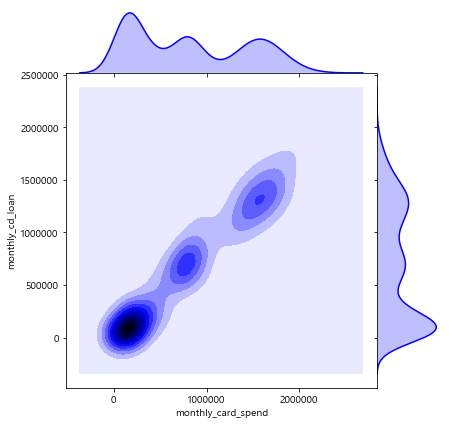

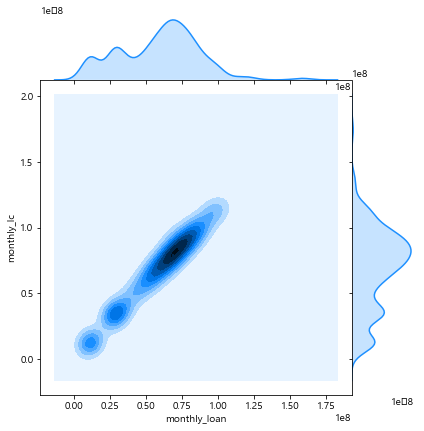

In [42]:
# 높은 상관관계를 보이는 변수 간의 Joint plot 시각화
ax=sns.jointplot('monthly_card_spend', 'monthly_cd_loan', data=city_ages,
                kind='kde', space=0, color='b')
ax.ax_joint.set_xticks([0, 1000000, 2000000])


ax1=sns.jointplot('monthly_loan', 'monthly_lc', data=city_ages,
                kind='kde', space=0, color='dodgerblue')

- monthly_cd_loan과 monthly_card_loan이 양의 상관관계를 가지고 있고, 각 Feature의 분포 또한 비슷하다.
- monthly_lc와 monthly_loan 또한 비슷한 상관관계와 분포를 갖는다.

# <br>
# 3. 분석

## 1) 고신용/저신용 그룹 간의 비교 분석

- 고신용/저신용 그룹을 구분하는 데 가장 영향을 많이 미치는 변수를 확인하기 위해 신용점수 1분위수(고신용)와 3분위수(저신용)로 분류

In [43]:
# 신용점수 1분위수와 3분위수 분류
three_quartile = city_ages.describe().avg_score['25%']
one_quartile = city_ages.describe().avg_score['75%']

one_of_quartile = city_ages[city_ages.avg_score >= one_quartile]
three_of_quartile = city_ages[city_ages.avg_score <= three_quartile]
one_of_quartile_total = city_ages_total[city_ages_total.avg_score >= one_quartile]
three_of_quartile_total = city_ages_total[city_ages_total.avg_score <= three_quartile]

In [44]:
# 신용점수 1분위수 - high credit, 3분위수 -low credit으로 분류
credit_level = []
for i in city_ages.avg_score:
    if i >= one_quartile:
        credit_level.append('high credit')
    elif i <= three_quartile:
        credit_level.append('low credit')
    else:
        credit_level.append('medium credit')
city_ages['credit_level'] = credit_level

In [45]:
TSNE_DF = city_ages[city_ages.credit_level!='medium credit']
y = TSNE_DF.credit_level
x = TSNE_DF.iloc[:, 7:-2]

In [46]:
# TSNE 알고리즘을 통해 3차원으로 시각화
model = TSNE(n_components=3, random_state=0)
transformed = model.fit_transform(x)
tsne_df = pd.DataFrame(transformed)
tsne_df = pd.concat((tsne_df,y.reset_index().drop('index', axis = 1)), axis = 1)

In [47]:
# plotly module을 이용한 3차원 scatter plot 함수 정의
def plotly_scatter(data, opacity=0.5, name = None):
    trace = go.Scatter3d(x=data.iloc[:, 0].values, y=data.iloc[:,1].values, z=data.iloc[:,2].values, 
                       mode='markers', 
                       marker=dict(size=3), 
                       opacity=opacity, 
                        name = name)
    return trace

In [48]:
# plotly module을 이용한 고신용/저신용 그룹 3차원 시각화
trace_low = plotly_scatter(tsne_df[tsne_df.credit_level=='low credit'], name = 'low credit')
trace_high = plotly_scatter(tsne_df[tsne_df.credit_level=='high credit'], name = 'hige credit')

data = [trace_low, trace_high]
layout = go.Layout(title='고신용/저신용 TSNE')
fig = go.Figure(data= data, layout=layout)
py.iplot(fig)

<img src="./data/credit_tsne2.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- TSNE로 차원축소하여 고신용(신용점수 1분위수)과 저신용(신용점수 3분위수)을 확인한 결과 군집화가 잘 되어있는 것을 확인 할 수 있다.
- 따라서, 고신용 그룹과 저신용 그룹으로 나누어 그룹 간의 차이를 확인해 보기로 한다.

## 2) Feature Selection
- 고객그룹의 평균평점(avg_score)에 영향을 많이 미치는 변수가 무엇인지 확인하기 위해, Random Forest를 이용하여 변수의 중요도를 확인해 보았다.
- 종속 변수(Dependent Varable) : avg_score

In [49]:
# 표준화 Scaler 생성
scaler = StandardScaler()

In [71]:
# 랜덤포레스트를 이용한 변수 중요도 도출
y = city_ages.avg_score
x = city_ages.iloc[:, 7:-2]
select = RFE(RandomForestRegressor(n_estimators=5, random_state=42), n_features_to_select = 5)
select.fit(x, y)

feature_importance_rfe = pd.DataFrame(list(zip(x.columns.values, select.get_support())))
feature_importance_rfe.columns = ['feature', 'importance']
feature_importance_rfe.sort_values("importance", ascending=False, inplace=True)
feature_importance_rfe

,feature,importance
2,num_usecard,True
6,monthly_bk_loan,True
13,ls_rep_loanb,True
1,num_opencard,True
10,monthly_sbk_loan,True
0,population,False
11,loan_commitment,False
16,credit_card_payment,False
15,mortgage_loan,False
14,credit_loan,False


회귀분석으로 살펴본 신용 점수와 회귀계수가 큰 변수 5개는 다음과 같다.

- num_usecard: 실제 사용 카드 수
- monthly_bk_loan: 은행업종 총 대출금액
- ls_rep_loanb: 일시상환대출 총 대출잔액
- num_opencard: 총 개설 카드 수
- monthly_sbk_loan: 저축은행업종 총 대출잔액


In [76]:
# 주요 5개 변수에 대해서 population을 고려한 data 전처리
one_num_opencard = one_of_quartile_total.groupby(['city']).total_num_opencard.sum() / one_of_quartile_total.groupby(['city']).population.sum()
three_num_opencard = three_of_quartile_total.groupby(['city']).total_num_opencard.sum() / three_of_quartile_total.groupby(['city']).population.sum()

one_num_usecard = one_of_quartile_total.groupby(['city']).total_num_usecard.sum() / one_of_quartile_total.groupby(['city']).population.sum()
three_num_usecard = three_of_quartile_total.groupby(['city']).total_num_usecard.sum() / three_of_quartile_total.groupby(['city']).population.sum()

one_monthly_bk_loan = one_of_quartile_total.groupby(['city']).total_monthly_bk_loan.sum() / one_of_quartile_total.groupby(['city']).population.sum()
three_monthly_bk_loan = three_of_quartile_total.groupby(['city']).total_monthly_bk_loan.sum() / three_of_quartile_total.groupby(['city']).population.sum()

one_lsrep_loanb = one_of_quartile_total.groupby(['city']).total_ls_rep_loanb.sum() / one_of_quartile_total.groupby(['city']).population.sum()
three_lsrep_loanb = three_of_quartile_total.groupby(['city']).total_ls_rep_loanb.sum() / three_of_quartile_total.groupby(['city']).population.sum()

one_monthly_sbk_loan = one_of_quartile_total.groupby(['city']).total_monthly_sbk_loan.sum() / one_of_quartile_total.groupby(['city']).population.sum()
three_monthly_sbk_loan = three_of_quartile_total.groupby(['city']).total_monthly_sbk_loan.sum() / three_of_quartile_total.groupby(['city']).population.sum()

In [77]:
# pyechart module을 활용한 bar plot 함수 정의
def bar_pyechart(data1, data2, title, subtitle):
    attr = data1.index
    temp1 = list(data1)
    temp2 = list(data2)
    v1 = list(map( lambda x : format(x / (sum(temp1)+sum(temp2)), '.3f'), temp1))
    v2 = list(map( lambda x : format(x / (sum(temp1)+sum(temp2)), '.3f'), temp2))

    bar = Bar(title, subtitle)
    bar.add("고신용 그룹", attr, v1, mark_line=["average"], mark_point=["max", "min"], is_axisline_show=True)
    bar.add("저신용 그룹", attr, v2, mark_line=["average"], mark_point=["max", "min"],legend_top="0%")
    bar.height = 1500
    bar.width = 1500
    
    return bar

In [79]:
# num_opencard
bar_0 = bar_pyechart(one_num_opencard, three_num_opencard, 
                    "num_opencard", "고신용/저신용 그룹 간의 지역별 총 개설카드 수 비교")

# num_usecard
bar_1 = bar_pyechart(one_num_usecard, three_num_usecard, 
                    "num_usecard", "고신용/저신용 그룹 간의 지역별 총 사용카드 수 비교")

# monthly_bk_loan
bar_2 = bar_pyechart(one_monthly_bk_loan, three_monthly_bk_loan, 
                     "monthly_bk_loan", "고신용/저신용 그룹 간의 지역별 은행업종 총 대출금액 비교")

# ls_rep_loanb
bar_3 = bar_pyechart(one_lsrep_loanb, three_lsrep_loanb, 
                     "ls_rep_loanb", "고신용/저신용 그룹 간의 지역별 분할상환대출 총 대출잔액 비교")

# monthly_sbk_loan
bar_4 = bar_pyechart(one_monthly_sbk_loan, three_monthly_sbk_loan, 
                     "monthly_sbk_loan", "고신용/저신용 그룹 간의 지역별 저축은행업종 총 대출금액 비교")

timeline = Timeline(is_auto_play=True, timeline_bottom=0, timeline_play_interval = '3000')
timeline.add(bar_2, '은행 대출금액')
timeline.add(bar_3, '분할상환 대출잔액')
timeline.add(bar_4, '저축은행 대출금액')
timeline.add(bar_0, '개설카드 수')
timeline.add(bar_1, '사용카드 수')
timeline

<img src="./data/res.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>
<img src="./data/num_opencard.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 고신용 그룹이 저신용 그룹보다 은행 대출금액, 일시상환 대출잔액이 많다.
- 저신용 그룹이 고신용 그룹보다 저축은행 대출금액, 개설카드 수, 사용카드 수가 더 많다.

# <br>
## 3) 지역별 연령별 군집 특성 비교 분석

- 지역별, 연령별 군집 특성을 확인하기 위해 K-Means 군집화를 하였다.

In [80]:
# 지역-연령 변수 city_ages 추가
city_ages_total['city_ages'] = city_ages_total['city'] + city_ages_total['ages']
cls_data = city_ages_total.groupby('city_ages').sum().divide(city_ages_total.groupby('city_ages').population.sum(), axis='index') # population을 고려한 data 전처리
cls_data = cls_data.iloc[:,3:]
cls_data.head()

,total_avg_score,total_avg_rat,total_num_opencard,total_num_usecard,total_monthly_card_spend,total_monthly_lc,total_monthly_loan,total_monthly_bk_loan,total_monthly_cd_loan,total_monthly_installments_loan,total_monthly_insurance_loan,total_monthly_sbk_loan,total_loan_commitment,total_inst_rep_loanb,total_ls_rep_loanb,total_credit_loan,total_mortgage_loan,total_credit_card_payment,total_credit_card_installments_payment
city_ages,,,,,,,,,,,,,,,,,,,
강원10대,770.078248,3.971285,1.644235,1.105930,2.087365e+05,9.980933e+06,8.799763e+06,3.686332e+06,7.917444e+04,1.912053e+06,3.026777e+05,2.217767e+06,5.211917e+05,4.544264e+06,3.547050e+06,7.906159e+06,9.671400e+06,2653.266332,1112.706389
강원20대,765.338362,4.000000,3.504324,1.757777,8.007658e+05,2.846278e+07,2.338268e+07,1.334280e+07,5.846043e+05,4.634860e+06,5.965862e+05,1.633941e+06,3.373335e+06,1.095130e+07,8.272950e+06,1.554215e+07,2.698253e+07,240623.810629,84106.057090
강원30대,788.395152,3.039804,4.077779,2.173707,1.581477e+06,5.815146e+07,4.857996e+07,3.280220e+07,1.121483e+06,5.455086e+06,1.859738e+06,1.256551e+06,9.153709e+06,1.967833e+07,1.796364e+07,2.589839e+07,5.828381e+07,840661.996887,249136.535468
강원40대,782.095543,3.505010,3.595772,2.082687,1.748969e+06,7.321820e+07,6.237056e+07,4.167436e+07,1.308364e+06,5.477082e+06,2.389691e+06,9.905097e+05,1.423471e+07,2.186212e+07,2.425976e+07,2.870087e+07,7.602098e+07,925054.595715,308625.604699
강원50대,787.821063,3.039853,2.858409,1.697342,1.382013e+06,7.934914e+07,6.937136e+07,4.839920e+07,1.010506e+06,4.283950e+06,1.674521e+06,6.046511e+05,2.002775e+07,1.772828e+07,3.001684e+07,2.756783e+07,8.885524e+07,709199.903969,281201.504481


### (1) Elbow method

In [81]:
# 최적 클러스터 개수 확인을 위한 Elbow Method
number_clusters = range(1, 20)
kmeans_list = []
for i in number_clusters:
    kmeans_list.append(KMeans(n_clusters=i))
scores = []
for i in range(len(kmeans_list)):
    scores.append(kmeans_list[i].fit(cls_data).score(cls_data))

trace = go.Scatter(
        x=list(number_clusters),
        y=scores,
        showlegend=False,
        marker=dict(color='dodgerblue')
        )

layout = go.Layout(
    height=500,
    width=800,
    title='Total ' + col_name
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<img src="./data/elbow_point.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 최적의 cluster 수는 7개인 것으로 확인하였다.

### (2) K-Means Clustering

In [82]:
# KMeans 알고리즘으로 학습
optimal_n_cluster = 7
kmeans = KMeans(n_clusters=optimal_n_cluster, max_iter=100000, random_state=4)
std_cls_data = scaler.fit_transform(cls_data) # 표준화
clusters = kmeans.fit_predict(std_cls_data)

In [83]:
#군집별 문헌 개수 세는 함수 정의
def ClusterCount(array):
    d = {}
    for cluster_ in array:
        if cluster_ in d:
            d[cluster_] += 1
        else:
            d[cluster_] = 1
    
    result = sorted(d.items(), key = (lambda x: x[1]), reverse = True)
    return result

In [84]:
# 클러스터 개수 확인
ClusterCount(clusters)

[(3, 37), (6, 25), (5, 24), (2, 23), (4, 16), (1, 16), (0, 3)]

In [85]:
# 클러스터 결과를 데이터 프레임에 추가
std_cls_df = pd.DataFrame(std_cls_data, columns=cls_data.columns, index=cls_data.index)
std_cls_df['K_Means'] = clusters

In [86]:
# 지역별/연령대별 정보를 각각의 column에 담기 위한 데이터 전처리
cities_list = []
ages_list = []
for i in std_cls_df.index:
    cities_list.append(i[:2])
    ages_list.append(i[2:])
    
std_cls_new = std_cls_df.copy()
std_cls_new['cities'] = cities_list
std_cls_new['ages'] = ages_list
std_cls_new = std_cls_new.iloc[:, -3:]

In [87]:
heatmap_df = pd.pivot_table(std_cls_new, index='cities', columns='ages',values=['K_Means'])
heatmap_df = heatmap_df.loc[['서울', '경기', '인천', '대구', '부산', '울산', '대전', '광주', '경남',  '충남', '충북', '경북', '전남',
       '전북', '제주']].copy()

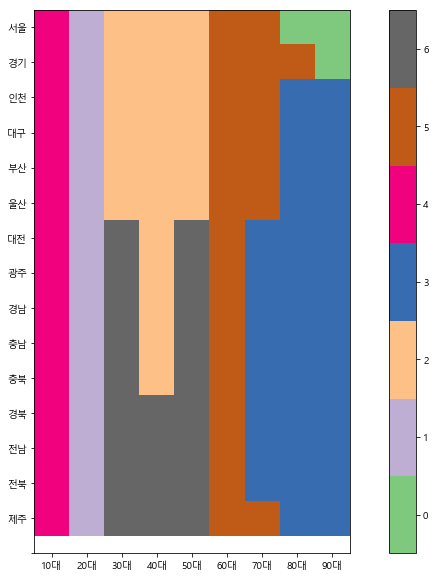

In [88]:
# 지역별 연령별 클러스터링 결과 시각화
cmap = cm.get_cmap('Accent', 7)
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(heatmap_df, cmap = cmap, vmin=-0.5, vmax=6.5)
fig.colorbar(im)
plt.xticks(range(0,9), heatmap_df.columns.get_level_values(1))
plt.yticks(range(0,16), heatmap_df.index)
plt.grid(False)
plt.show()

#### 군집 결과

- cluster0: 수도권 노년층
- cluster1: 20대
- cluster2: 수도권 및 광역시 30,40,50대
- cluster3: 비수도권 노년층
- cluster4: 10대
- cluster5: 60,70대
- cluster6: 비광역시 30,40,50대

결과에 따르면, 연령대 뿐만 아니라 수도권, 광역시와 같은 지역별 특성에 따라서도 군집화가 이루어짐을 확인할 수 있다.

<br>
- 따라서 군집별 금융활동 특성을 확인하면 각 군집에 적합한 금융 서비스를 제공할 수 있다. <br>
- 이에 Factor Analysis를 통해 변수를 3차원으로 축소하여 군집화를 시각화하고, 군집화에 영향을 미치는 변수들을 확인하였다.

### (3)  Factor Analysis

In [89]:
FA_df = std_cls_df.iloc[:,:-1] # 클러스터링 결과 column을 제외

In [90]:
# FactorAnalysis를 사용하여 3차원으로 Feature를 축소
FA = decomposition.FactorAnalysis(n_components=3) 
FA_x = FA.fit_transform(FA_df)
FA_result = pd.DataFrame(FA_x)

columns_list = []
for i in FA_df.columns:
    columns_list.append(i[6:])

FA_df = pd.DataFrame(np.round(FA.components_*100), columns = columns_list, index=['x축','y축','z축']).T
FA_df

,x축,y축,z축
avg_score,60.0,53.0,-42.0
avg_rat,-71.0,-23.0,60.0
num_opencard,17.0,-93.0,24.0
num_usecard,21.0,-94.0,21.0
monthly_card_spend,52.0,-85.0,-0.0
monthly_lc,98.0,11.0,-2.0
monthly_loan,100.0,9.0,0.0
monthly_bk_loan,97.0,21.0,3.0
monthly_cd_loan,50.0,-83.0,5.0
monthly_installments_loan,22.0,-91.0,22.0


X축은 monthly_loan, monthly_bk_loan, mortgage_loan등이 높은 값을 가지고,<br/>
Y축은 num_opencard, num_usedcard, monthly_card_spend, monthly_cd_loan등이 높은 값을 가지고,<br/>
Z축은 avg_rat, avg_score등이 높은 값을 가진다.<br/><br/>

각각의 축에 가장 높은 값을 가진 데이터를 바탕으로 추정을 해보면<br/>
X축은 대출, Y축은 카드, Z축은 신용정보로 이름을 붙일 수 있다.

In [91]:
FA_result['cls'] = clusters

In [92]:
trace_list = []
for i in range(optimal_n_cluster):
    trace_list.append(plotly_scatter(FA_result[FA_result.cls==i], opacity=0.8, name="cluster {}".format(i)))

In [93]:
data = trace_list

layout = go.Layout(title='Factor analysis clustering')

fig = go.Figure(data= data, layout=layout)
py.iplot(fig)

<img src="./data/fa_clustering.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- Factor Analysis에서 K-Means 군집 결과를 확인한 결과, 군집화가 잘 된 것을 알 수 있다.

- 예를들어, 0번째 cluster인 수도권 노년층 경우, 3개의 축 모두에서 높은 결과를 보인다. <br> 즉, 대출(x축)과 양의 관계를 나타내므로 대출 금액이 많은 것을 알 수 있다. 카드(y축)과 관련된 항목에서는 음의 관계이므로 카드 사용이 낮다. 신용정보(z축)에서는 신용이 낮은 것을 알 수 있다.

# <br>
# <제주 데이터>

In [94]:
# 제공받은 제주 데이터 load
df = pd.read_csv("data/jeju_financial_life_data.csv", encoding='utf-8')
df.head()

,zip_cd,year_month,x_axis,y_axis,sex,age,job_majorc,job_smallc,job_public,job_profession,...,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,medium_resid_rat,large_resid_rat,vehicle_own_rat
0,63299,201902,126.565889,33.513210,1,54,0.0,0.166667,0.000000,0.000000,...,24285196,11419148,8863595,55550000,0,55550000,5,-999999.0,-999999.0,0.000000
1,63560,201902,126.497121,33.247225,1,59,0.0,0.125000,0.000000,0.000000,...,108571077,25896955,13317443,0,200000000,74421721,4,-999999.0,-999999.0,0.000000
2,63560,201902,126.497121,33.247225,2,49,0.0,0.250000,0.000000,0.000000,...,26424335,12015311,12015311,40833359,0,40833359,2,-999999.0,-999999.0,0.000000
3,63560,201902,126.497121,33.247225,1,54,0.0,0.181818,0.090909,0.090909,...,647716901,39952556,21558153,36697792,0,706300496,4,-999999.0,-999999.0,0.166667
4,63560,201902,126.497121,33.247225,1,49,0.0,0.250000,0.000000,0.000000,...,248232725,35712501,5568751,0,0,626810674,5,-999999.0,-999999.0,0.000000


## 1. 직업관련 및 부채관련 분포

In [95]:
# 직업관련 및 부채관련 각 변수들의 평균값을 계산하여  Pie Chart 확인.
job_dict = df.iloc[:,6:13].mean().to_dict()
debt_dict = df.iloc[:,18:23].mean().to_dict()

attr1 = list(job_dict.keys())
attr2 = list(debt_dict.keys())
v1 = list(job_dict.values())
v2 = list(debt_dict.values())

pie_1 = Pie("제주 데이터", "직업 분포 파이 그래프")
pie_1.add(
    "차트1",
    attr1,
    v1,
    is_label_show=True,
    radius=[30, 55],
    rosetype="radius",
    legend_top="10%",
)
pie_2 = Pie("제주 데이터", "부채 분포 파이 그래프")
pie_2.add(
    "차트2",
    attr2,
    v2,
    is_label_show=True,
    radius=[30, 55],
    rosetype="radius",
    legend_top="10%",
)

timeline = Timeline(is_auto_play=True, timeline_bottom=0,timeline_play_interval = '3000')
timeline.add(pie_1, '직업 분포')
timeline.add(pie_2, '부채 분포')

timeline

<img src="./data/jeju_job.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>
<img src="./data/jeju_debt.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 직업관련 변수의 분포를 확인한 결과, 무직(52.98%), 자영업(21.03%), 중소기업(14.36%) 순으로 많은 비율을 차지한다.
- 부채관련 변수의 분포를 확인한 결과, 물건담보대출(44.47%), 주택담보대출(31.84%), 비은행대출(14.09%) 순으로 많은 비율을 차지한다.

## 2. 성별 소득/소비/부채

In [96]:
# 성별 기준으로 소득, 소비, 부채의 평균을 계산
sex_income = df.groupby('sex').avg_income.mean()
sex_spend = df.groupby('sex').avg_spend.mean()
sex_debt = df.groupby('sex').avg_debt.mean()

In [97]:
# 표에 들어갈 데이터 추가 및 인덱스 생성
sex_df = pd.DataFrame([sex_income, sex_spend, sex_debt]).T
sex_df['avg_savings'] = ((sex_df.avg_income - sex_df.avg_spend)).values
sex_df_T = sex_df.T
sex_df_T.columns = ['남성','여성']
table_data = np.vstack((np.array(['평균값','남성','여성']),
               np.array(np.round(sex_df_T,2).reset_index())))

index = sex_df_T.index

# trace 생성
trace1 = go.Bar(x=index, y=sex_df.T[1], xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='남성')
trace2 = go.Bar(x=index, y=sex_df.T[2], xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='여성')

# 시각화 
figure = ff.create_table(table_data.T, height_constant=60)
figure.add_traces([trace1, trace2])
figure['layout']['xaxis2'] = {}
figure['layout']['yaxis2'] = {}

figure.layout.yaxis.update({'domain': [0, .45]})
figure.layout.yaxis2.update({'domain': [.6, 1]})
figure.layout.yaxis2.update({'anchor': 'x2'})
figure.layout.xaxis2.update({'anchor': 'y2'})
figure.layout.yaxis2.update({'title': '단위(원)'})

figure.layout.margin.update({'t':75, 'l':50})
figure.layout.update({'title': '제주도 성별 소득/소비/부채'})

figure.layout.update({'height':700, 'width':700})

py.iplot(figure)

<img src="./data/jeju_overview.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 제주도 남성이 여성보다 소득/소비/부채/저축 모두 높다.

## 3. 연령별 소득/소비/부채

In [101]:
# 연령별 기준으로 소득, 소비, 부채의 평균을 계산
age_income = df.groupby('age').avg_income.mean()
age_spend = df.groupby('age').avg_spend.mean()
age_debt = df.groupby('age').avg_debt.mean()
age_df = pd.DataFrame([age_income, age_spend, age_debt])

In [104]:
# 연령별 소득, 소비, 부채 bar chart 시각화
attr = list(age_income.to_dict().keys())
v1 = list(age_income.to_dict().values())
v2 = list(age_spend.to_dict().values())
v3 = list(age_debt.to_dict().values())

v1 = list(map(lambda x : np.round(x / (sum(v1)),3),v1))
v2 = list(map(lambda x : np.round(x /(sum(v2)),3),v2))
v3 = list(map(lambda x : np.round(x /(sum(v3)),3),v3))

bar = Bar("연령별 소득/소비/부채 비교 그래프")
bar.add('소득', attr, v1, mark_point=["max", "min"])
bar.add('소비', attr, v2, mark_point=["max", "min"])
bar.add('부채', attr, v3, mark_point=["max", "min"])

bar.width=900
bar

<img src="./data/jeju_income_etc.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 소득은 40, 50대가 높고, 소비는 30중반 ~ 40대가 높으며, 부채는 50대 ~ 60대중반이 높다.

# <br>
## 4. 지역별 군집화

## 1) Data preprocessing

In [105]:
print(len(df[df['medium_resid_rat']==-999999.0]))
print(len(df[df['large_resid_rat']==-999999.0]))

cls_data = df.drop(['medium_resid_rat', 'large_resid_rat'], axis = 1)

7873
7873


- 총 10,422개의 데이터 중 'medium_resid_rat'와 'large_resid_rat' 열에서 7,873개의 데이터가 null값인 -999999.0에 해당한다.
- 따라서, 두 열을 제외하고 분석을 진행하였다.


In [106]:
# zip_cd 별 각 column의 평균 값 사용
cls_data = cls_data.groupby('zip_cd').mean()

# 군집화에 필요한 column만 선택하여 사용함
cls_data = cls_data[['job_majorc',
       'job_smallc', 'job_public', 'job_profession', 'job_self', 'job_none',
       'job_other', 'avg_income', 'med_income', 'avg_spend',
       'avg_foreign_spend', 'avg_debt', 'avg_debt_credit', 'avg_debt_noneb',
       'avg_debt_mortgage', 'avg_debt_deposit', 'avg_debt_collateral',
       'avg_credit_rat', 'vehicle_own_rat']]

# 각 column을 표준화
scaler = StandardScaler() 
std_cls_data = scaler.fit_transform(cls_data)

## 2) Elbow method

In [107]:
# 최적 클러스터 개수 확인을 위한 Elbow Method
number_clusters = range(1, 20)
kmeans_list = []
for i in number_clusters:
    kmeans_list.append(KMeans(n_clusters=i, random_state=1, max_iter=10000))
scores = []
for i in range(len(kmeans_list)):
    scores.append(kmeans_list[i].fit(std_cls_data).score(std_cls_data))

trace = go.Scatter(
        x=list(number_clusters),
        y=scores,
        showlegend=False,
        marker=dict(color='dodgerblue')
        )

layout = go.Layout(
    height=500,
    width=800,
    title='Elbow score'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<img src="./data/elbow_point2.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 최적의 cluster 수는 6개인 것으로 확인하였다.

## 3) K-Means clustering

In [108]:
# KMeans 알고리즘으로 학습
optimal_n_cluster = 6
kmeans = KMeans(n_clusters=optimal_n_cluster, max_iter=100000, random_state=4)
clusters = kmeans.fit_predict(std_cls_data) 

In [109]:
# 클러스터 개수 확인
ClusterCount(clusters)

[(5, 197), (1, 167), (0, 76), (3, 31), (2, 2), (4, 1)]

In [110]:
# 클러스터 결과를 데이터 프레임에 추가
std_cls_df = pd.DataFrame(std_cls_data, columns=cls_data.columns, index=cls_data.index)
std_cls_df['K_Means'] = clusters

## 4)  3차원으로 군집화 결과 확인

- PCA(주성분분석)을 통해 군집화가 잘 되었는지 3차원 좌표평면에서 확인하였다.

In [111]:
# PCA를 통해 3차원 축소
pca = decomposition.PCA(n_components=3)
pca_x = pca.fit_transform(std_cls_data)

pca_df = pd.DataFrame(pca_x)
pca_df['cls'] = clusters

In [112]:
# 3차원 시각화
trace_list = []
for i in range(optimal_n_cluster):
    trace_list.append(plotly_scatter(pca_df[pca_df.cls==i], opacity=0.7, name="cluster {}".format(i)))
data = trace_list

layout = go.Layout(title='Jeju PCA clustering')

fig = go.Figure(data= data, layout=layout)
py.iplot(fig)

<img src="./data/jeju_pca.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

## 5) 지도 시각화

- zip_code별로 각 Feature의 평균을 계산하여 클러스터링 결과를 제주지도에 시각화하였다

In [113]:
# 위도/경도와 클러스터 결과를 DataFrame으로 생성
geo_data = df.groupby('zip_cd').mean()
geo_data = geo_data[['x_axis', 'y_axis']]
geo_data['cluster'] = clusters

In [114]:
#Plotly module을 활용한 지도 시각화 함수 정의
def plotly_map(data, opacity=0.5, name=None):
    
    palette = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'navy', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']
    
    trace = go.Scattermapbox(lon=data.iloc[:, 0].values,
                             lat=data.iloc[:, 1].values,
                             mode='markers',
                             marker=go.scattermapbox.Marker(size = 9, 
                                                            opacity = opacity,
                                                            color = palette[data.iloc[0, 2]]),
                             name=name,
                             text=data.iloc[:, 2].values)
    return trace

In [115]:
# plotly module을 활용한 지도 시각화
trace_list = []
for i in range(optimal_n_cluster):
    trace_list.append(plotly_map(geo_data[geo_data.cluster==i], opacity=0.7, name="cluster {}".format(i)))

data = trace_list

#Mapbox Default public token
mapbox_access_token = 'pk.eyJ1IjoiY2hvY29zb25nZWVlIiwiYSI6ImNqeG9sbnVvczA4YTkzYm54Nm1rMTNheHYifQ.R0Qk3dcc3Kl_uAwCQTgAtA'

layout = go.Layout(title='Jeju Clustering',
                   autosize = True,
                   height = 600, width = 900,
                   mapbox = go.layout.Mapbox(accesstoken = mapbox_access_token,
                                             bearing=0,
                                             center=go.layout.mapbox.Center(lat=geo_data['y_axis'].mean()-0.1,
                                                                            lon=geo_data['x_axis'].mean()+0.05),
                                             pitch=0,
                                             zoom=9,
                                             style='light'                          
                                             )
                  )

fig = go.Figure(data= data, layout=layout)
py.iplot(fig)

<img src="./data/jeju_clustering.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 지도 시각화 결과, 지역적인 특성(도심지, 관광지 등)에 따라 군집화가 이루어진 결과를 확인할 수 있다.
- 이에 각 군집이 가지는 특성과 위치를 확인해보았다.

## 6) 군집 결과 분석

- 각 데이터는 해당 Column의 전체 평균 값 대비 해당 클러스터의 값을 의미한다.

In [117]:
# 군집별 전체 feature들의 전체 평균값 대비 비율을 계산
cls_data['cluster'] = clusters
cls_df_list=[]
for i in range(optimal_n_cluster):
    cls_df_list.append(cls_data[cls_data.cluster == i].mean().div(cls_data.mean()))

# DataFrame 생성
cls_ratio = pd.DataFrame(cls_df_list, index=['cluster0','cluster1','cluster2','cluster3','cluster4','cluster5'])
np.round(cls_ratio, 2)

,job_majorc,job_smallc,job_public,job_profession,job_self,job_none,job_other,avg_income,med_income,avg_spend,avg_foreign_spend,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,vehicle_own_rat,cluster
cluster0,1.32,1.08,1.84,1.38,0.74,0.97,1.39,1.07,1.08,1.31,1.49,1.06,1.17,1.09,1.16,1.43,1.06,0.90,1.10,0.00
cluster1,0.93,0.82,0.68,0.72,1.44,0.92,0.73,0.99,0.98,0.85,0.84,1.05,1.04,0.98,1.01,0.91,1.00,1.03,1.05,0.38
cluster2,0.00,1.38,0.93,1.04,0.85,0.97,1.45,3.63,1.37,1.39,3.11,6.56,2.46,4.61,1.68,1.18,4.97,0.83,3.69,0.76
cluster3,0.97,1.18,0.87,1.82,1.14,0.85,1.29,1.26,1.19,1.52,2.32,2.26,1.38,2.41,1.93,1.27,2.21,1.01,1.47,1.13
cluster4,1.61,1.14,0.00,0.00,1.41,0.94,0.00,4.60,4.67,0.72,0.01,2.03,1.56,0.48,0.63,0.00,1.27,1.23,2.44,1.51
cluster5,0.95,1.09,0.97,0.96,0.70,1.10,1.04,0.90,0.94,0.93,0.73,0.68,0.82,0.72,0.78,0.87,0.75,1.01,0.81,1.89


- cluster 6개 중, 특징이 두드러진 cluster0과 cluster1에 대한 분석을 진행하였다.

### (1) cluster0 분석 결과

In [119]:
np.round(cls_ratio, 2).iloc[0:1]

,job_majorc,job_smallc,job_public,job_profession,job_self,job_none,job_other,avg_income,med_income,avg_spend,avg_foreign_spend,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,vehicle_own_rat,cluster
cluster0,1.32,1.08,1.84,1.38,0.74,0.97,1.39,1.07,1.08,1.31,1.49,1.06,1.17,1.09,1.16,1.43,1.06,0.9,1.1,0.0


- 자영업과 무직의 비율이 낮은 반면, 대기업과 공기업을 비롯한 직업군의 비율이 높다. 
- 지도 상에서 확인한 결과 도심지에 위치하여 직장인의 비율이 높다.
- 또한, 국내/해외 소비가 평균 이상인데 비해 부채는 상대적으로 낮은 편이다.

In [120]:
# cluster0을 지도에 시각화
geo_data_0 = geo_data[geo_data.cluster==0]
mapping = folium.Map(location = [geo_data_0['y_axis'].mean()-0.1, geo_data_0['x_axis'].mean()],
                    zoom_start=10.46)

palette = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']
for i in geo_data_0.index:
    folium.CircleMarker([geo_data_0['y_axis'][i], geo_data_0['x_axis'][i]],
                        popup = str(i),
                        radius = 4,
                        color=None,
                        fill_color = palette[geo_data_0['cluster'][i]],
                        fill_opacity = 0.6).add_to(mapping)
mapping

<img src="./data/jeju_cls1.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

### (2) cluster1 분석 결과

In [121]:
np.round(cls_ratio, 2).iloc[1:2]

,job_majorc,job_smallc,job_public,job_profession,job_self,job_none,job_other,avg_income,med_income,avg_spend,avg_foreign_spend,avg_debt,avg_debt_credit,avg_debt_noneb,avg_debt_mortgage,avg_debt_deposit,avg_debt_collateral,avg_credit_rat,vehicle_own_rat,cluster
cluster1,0.93,0.82,0.68,0.72,1.44,0.92,0.73,0.99,0.98,0.85,0.84,1.05,1.04,0.98,1.01,0.91,1.0,1.03,1.05,0.38


- 지도상에서 제주시를 제외한 제주도 외곽지역에 분포하고 있다.
- cluster1은 cluster0과는 반대로 대기업과 공기업을 비롯한 직업군의 비율이 낮고, 자영업의 비율이 높다.
- 국내/해외소비가 낮은 것에 비하면 cluter1의 부채가 높은편이다.

In [122]:
# cluster1을 지도위에 시각화
geo_data_1 = geo_data[geo_data.cluster==1]
mapping = folium.Map(location = [geo_data_1['y_axis'].mean(), geo_data_1['x_axis'].mean()],
                    zoom_start=10.46)

palette = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']
for i in geo_data_1.index:
    folium.CircleMarker([geo_data_1['y_axis'][i], geo_data_1['x_axis'][i]],
                        popup = str(i),
                        radius = 4,
                        color=None,
                        fill_color = palette[geo_data_1['cluster'][i]],
                        fill_opacity = 0.6).add_to(mapping)
mapping

<img src="./data/jeju_cls2.png" alt="지역별 평균 평점 스크린샷" style="width: 800px;"/>

- 위에서 확인한 결과와 같이 지역적 위치에 따라 동일한 금융생활 특성을 보이는 것을 알 수 있다. 
- 지리적 정보와 지역주민의 금융 활동 패턴을 고려한다면, 최적의 금융 서비스를 제공할 수 있을 것이다.

# <br>
# 5. 인사이트 발굴

<center><font size=5><b><i>" 제주농가 공급과잉으로 인한 부채규모 확대로 생산기반 붕괴 우려 지적<br/>부채규모 6,523만원으로 전국 평균대비 2.5배로 높아 "</i></b></font><center>
<br/>
<center><a href="http://www.council.jeju.kr/notice/bodo/list.do;jsessionid=M5XfIW7EGt0tiyaLVtlKNGrNmMmemK1tTdlQU5kTwDt9WduMUC3sGnIQs5eWaeRS.CouncilDB_servlet_engine1?act=view&seq=269791&pc=true">“제주농업 현황과 정책보완과제”보고서 “정책차롱 제1호”</a>, 제주특별자치도의회 정책연구실(2019.02)</center>

## 1) 현황
- 제주농가는 과잉생산과 농산물가격의 약세로 인하여 소득의 불안정성이 높아지고 있다.
- 이로 인해 부채규모가 확대되었고, 부채규모는 평균 6,523만원으로 전국 평균대비 2.5배로 높다.

## 2) 가설
- 농가의 부채규모가 확대되는 만큼, 농가가 많은 지역일수록 부채의 규모가 많을 것으로 예상된다.

## 3) 가설 검증


### (1) 위도, 경도 정보로 읍/면/동 정보 얻어내기

In [123]:
# 제주 데이터에서 위도, 경도 정보만 추출
location_df = df[['x_axis', 'y_axis']]

# unique한 위도, 경도 정보만 추출
unique_location = location_df.drop_duplicates().copy()
unique_location = unique_location.reset_index()
unique_location.drop('index', axis=1, inplace=True)

In [125]:
# 제주도의 우편변호와 행정동명 등의 정보가 담긴 공공데이터 load
zipcode_df = pd.read_csv('./data/제주특별자치도.txt', sep='|', encoding='euc-kr', engine='python')

데이터출처: 인터넷우체국, 지역별 주소 DB 중 '제주특별자치도.txt'<br/>
기준시간: 2019년 5월 14일 기준 데이터

In [126]:
# 제주도의 읍/면/동 정보만 추출
jeju_dong_list = list(zipcode_df['행정동명'].unique())
jeju_dong_list.remove(np.nan)

```
# Google Reverse Geocoding API를 이용하여 위도, 경도 -> 주소정보 얻어오기
GOOGLE_API_KEY = "GOOGLE_API_KEY를 적어야함"
request_format = "https://maps.googleapis.com/maps/api/geocode/json?latlng={},{}&language=ko&key={}"

request_results =[]
for lat, lng in zip(unique_location['y_axis'], unique_location['x_axis']):
    r = requests.get(request_format.format(lat, lng, GOOGLE_API_KEY))
    request_results.append(json.loads(r.content))
```

- 위의 코드 중 GOOGLE_API_KEY 변수에 Reverse Geocoding API를 이용할 수 있는 Google API Key를 입력하면 코드가 실행된다.
- 편의상 위의 코드를 이용하여 얻은 데이터를 JSON파일로 data 폴더에 저장해두었다.
- 시각화 코드 내에서는 미리 저장해놓은 데이터를 이용하여 진행하였다.

In [127]:
# 위에서 저장한 Json file load
with open('./data/위도경도로얻은주소들.json', 'r') as f:
    request_results = json.load(f)

In [128]:
# 전체 주소에서 행정 단위 읍/면/동을 추출
dong_list = []
for i in range(len(request_results)):
    added=False
    for data in request_results[i]['results']:
        m = re.search(r"\b\w+[읍|면|동]\b", data['formatted_address'])
        try:
            word = m.group()
        except:
            continue
        if word in jeju_dong_list:
            dong_list.append(word)
            added=True
            break
            
    if not added:
        for data in request_results[i]['results']:
            try:
                m = re.search(r"\b\w+[읍|면|동]\b", data['plus_code']['compound_code'])
                word = m.group()
            except:
                continue
            if word in jeju_dong_list:
                dong_list.append(word)
                added=True
                break

In [129]:
# 위도, 경도 정보와 읍/면/동 정보가 담긴 컬럼 생성
unique_location['행정동명'] = dong_list

# 제주데이터 테이블과 읍/면/동 정보가 담긴 테이블 연결
jeju_df = pd.merge(df, unique_location).copy()

### (2) 시각화를 위한 데이터 전처리

In [131]:
# 읍/면/동별 평균 수입
avg_income_df = jeju_df.groupby(['행정동명'])[['avg_debt']].mean().reset_index()

# 읍/면/동별, 나이대별 대출잔액 평균들
avg_debt_df = jeju_df.groupby(['행정동명','age'])[['avg_debt_credit', 'avg_debt_noneb', 'avg_debt_mortgage', 'avg_debt_deposit', 'avg_debt_collateral']].mean().reset_index()

In [132]:
# 전국 GeoJSON 데이터 로드
with open('./data/skorea-submunicipalities-2018-geo.json') as f:
    json_data = json.load(f)

#(출처 : https://github.com/southkorea/southkorea-maps)

In [133]:
# 전국 GeoJSON 데이터에서 제주 GeoJSON 데이터만 필터링
filtered_list = []
for i, feature in enumerate(json_data['features']):
    dong = feature['properties']['name']
    sample_lat = feature['geometry']['coordinates'][0][0][0][1]
    if dong in jeju_dong_list:
        if sample_lat < 34:
            filtered_list.append(feature)
            
filtered_json_data = json_data.copy()
filtered_json_data['features'] = filtered_list

In [134]:
# 한 읍/면/동 내에 포함된 여러 위도, 경도 값의 평균값을 하나의 대표하는 값으로 만듦
unique_location_justone = unique_location.groupby('행정동명').mean()
unique_location_justone = unique_location_justone.reset_index()

### (3) 시각화

In [135]:
# Vincent
# folium vincent marker를 위한 Json file 저장
for i in range(len(unique_location_justone)):
    data = unique_location_justone.loc[i]
    dong = data['행정동명']
    
    bar = vincent.StackedBar(avg_debt_df[avg_debt_df['행정동명']==dong], 
                             columns=['avg_debt_credit','avg_debt_noneb', 'avg_debt_mortgage',
                                      'avg_debt_deposit', 'avg_debt_collateral'], 
                             key_on='age')
    
    bar.width = 400
    bar.height = 200
    
    bar.x_axis_properties(label_align='center')
    bar.x_axis_properties(title_offset=5)
    bar.y_axis_properties(title_offset=-50)
    
    bar.axis_titles(x='{}_연령대'.format(dong), y='대출잔액')
    bar.legend(title="columns".format(dong))
    bar.to_json('vega_'+dong+'.json')

In [136]:
# vincent 및 folium module을 활용한 지역별 총 부채 금액 및 연령별 부채 구성 시각화
jeju_map = folium.Map(location=[33.365010, 126.520319], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(
    geo_data=filtered_json_data,
    data=avg_income_df,
    columns=['행정동명', 'avg_debt'],
    key_on='feature.properties.name',
    fill_color='YlGn',
).add_to(jeju_map)

for i in range(len(unique_location_justone)):
    data = unique_location_justone.loc[i]
    loc = [data['y_axis'], data['x_axis']]
    dong = data['행정동명']
    with open('vega_'+dong+'.json') as f:
        vis = json.load(f)
    
        
    folium.RegularPolygonMarker(
        location=loc,
        popup=folium.Popup(max_width=700).add_child(
            folium.Vega(vis, width=630, height=260),
        ),
        color='#FFA301',
        fill_color='#FFA301',
        fill_opacity=1,
        radius=5
    ).add_to(jeju_map)

jeju_map.save('jeju_avg_debt.html')

<a href="./jeju_avg_debt.html">지역별 채무 평균 보유액 & 연령대별 대출 유형별 채무 평균 보유액 (클릭하세요)</a><br/>
- 커널 환경에 따라 jupyter notebook에 inline으로 뜨지 않는 상황을 위해 html 링크를 첨부
- 아래의 이미지는 html링크를 클릭하면 나타나는 화면의 스크린샷

<img src="./data/jeju_avg_debt.png" alt="지역별 채무 평균 보유액 & 연령대별 대출 유형별 채무 평균 보유액 스크린샷" style="width: 800px;"/>

In [137]:
# 제주시, 서귀포시 지역별 농가 현황 데이터 
제주시농가 = pd.read_excel("./data/농업경영체현황(농가)_지역별농가현황_제주시.xlsx")
서귀포시농가 = pd.read_excel('./data/농업경영체현황(농가)_지역별농가현황_서귀포시.xlsx')

# 하나의 DataFrame 합치기
농가data=pd.concat([제주시농가, 서귀포시농가], ignore_index=True)

# 경영체수 기준으로 내림차순 정렬 
농가data=농가data[농가data['읍면동']!='총계'].sort_values(by='경영체수(건)', ascending=False)
농가data[['읍면동', '경영체수(건)']].head(10)


,읍면동,경영체수(건)
73,남원읍,4042.0
42,애월읍,3857.0
72,대정읍,2914.0
43,구좌읍,2651.0
41,한림읍,2554.0
44,조천읍,2528.0
74,성산읍,2391.0
22,노형동,2137.0
45,한경면,2086.0
76,표선면,2050.0


데이터출처 : 「농업경영체 현황(농가) : 지역별 농가 현황」, 농업경영체 등록정보 조회 서비스, 농림축산식품부 <br>
기간 : 2018년 <br>
단위 : 경영체 수(건)

<br/>

### (4) 데이터 확인 결과

제주도의 전체 43개 행정동 중, 농가 수 기준 상위 10개 지역의 평균 부채 순위는 다음과 같다.
    
| No | 지역명 | 부채순위 |
| --- | --- | --- |
| 1 | 남원읍 | 6위 |
| 2 | 애월읍 | 15위 |
| 3 | 대정읍 | 4위 |
| 4 | 구좌읍 | 20위 |
| 5 | 한림읍 | 11위 |
| 6 | 조천읍 | 16위 |
| 7 | 성산읍 | 14위 |
| 8 | 노형동 | 10위 |
| 9 | 한경면 | 3위 |
| 10 | 표선면 | 13위 |

농가 수 상위 10개 지역 모두 부채기준 상위 그룹에 위치하였으며, 상관계수는 0.6860에 해당한다. <br/>
즉, 농가 수가 많을수록 부채가 많음을 확인할 수 있다.



<br>
이처럼 부채금액과 부채 종류별 금액을 시각화하면 한눈에 확인하기 용이하다.
<br>
<b>따라서 향후 대출을 포함한 금융 서비스, 또는 신용등급평가를 고려할 때도 위와 같은 대시보드를 통해 비슷한 인사이트를 얻을 수 있을것으로 기대된다.</b>